In [1]:
""" An attempt to obtain impressive results on MNIST.
    Code extracted from: https://github.com/shahariarrabby/Mnist_cnn_Swish
    Expected results > 99.5%
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# For adding new activation function
from keras import backend as K
from keras.datasets import mnist
from keras.utils.generic_utils import get_custom_objects
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Load data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("Y_train original shape", Y_train.shape)

X_train original shape (60000, 28, 28)
Y_train original shape (60000,)


In [3]:
# Normalization
nb_classes = 10
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [5]:
# Set the random seed
random_seed = 2

In [6]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

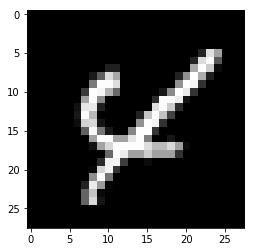

In [7]:
# Some examples
g = plt.imshow(X_train[0], cmap='binary_r')

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
# test = test.values.reshape(-1,28,28,1)
print(X_train.shape, X_val.shape, X_test.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (10000, 28, 28, 1)


In [9]:
def swish(x):
    return (K.sigmoid(x) * x)

def e_swish_2(x):
    sigmoid = K.sigmoid(x)
    return K.maximum(x*sigmoid, x*(2-sigmoid))

In [10]:
activations = [e_swish_2, "relu",  swish]
names = activations[:]
for i,a in enumerate(names):
    if not isinstance(a, str):
        names[i] = a.__name__
print(names)

['e_swish_2', 'relu', 'swish']


In [11]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
def create(act):
    model = Sequential()
    # First conv block
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=act, input_shape = (28,28,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=act))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # Second conv block
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=act))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=act))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    # Classification
    model.add(Flatten())
    model.add(Dense(256, activation=act ))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "sigmoid"))
    
    model.summary()
    return model

In [12]:
# Debugging pytorch
model = create("relu")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [13]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [14]:
# Define the optimizer - Common to all models
opt = adam(lr=0.001, epsilon=1e-08, decay=0.0)
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
# Common params 
epochs = 35    # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [14]:
whole = []
for i, act in enumerate(activations):
    partial = []
    for i in range(5):
        # Create and compile the model
        model = create(act)
        # Compile the model
        model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["accuracy"])
        # Train the model
        history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                                      epochs = epochs, validation_data = (X_val,Y_val),
                                      verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                                      , callbacks=[learning_rate_reduction])
        scores = model.evaluate(X_test, Y_test)
        ind = [history.history, scores]
        print(ind)
        partial.append(ind)
    
    print(partial)
    whole.append(partial)
    print(whole)

Epoch 1/35
627/627 [==============================] - 92s 147ms/step - loss: 0.3494 - acc: 0.8922 - val_loss: 0.0496 - val_acc: 0.9850
Epoch 2/35
627/627 [==============================] - 81s 129ms/step - loss: 0.1262 - acc: 0.9634 - val_loss: 0.0369 - val_acc: 0.9880
Epoch 3/35
627/627 [==============================] - 82s 130ms/step - loss: 0.1006 - acc: 0.9706 - val_loss: 0.0317 - val_acc: 0.9908
Epoch 4/35
627/627 [==============================] - 80s 128ms/step - loss: 0.0892 - acc: 0.9735 - val_loss: 0.0338 - val_acc: 0.9907
Epoch 5/35
627/627 [==============================] - 80s 127ms/step - loss: 0.0846 - acc: 0.9752 - val_loss: 0.0309 - val_acc: 0.9905
Epoch 6/35
627/627 [==============================] - 80s 127ms/step - loss: 0.0809 - acc: 0.9771 - val_loss: 0.0250 - val_acc: 0.9928
Epoch 7/35
627/627 [==============================] - 80s 127ms/step - loss: 0.0757 - acc: 0.9778 - val_loss: 0.0296 - val_acc: 0.9908
Epoch 8/35
627/627 [==============================] - 8

Epoch 1/35
627/627 [==============================] - 80s 128ms/step - loss: 0.9143 - acc: 0.7126 - val_loss: 0.1804 - val_acc: 0.9585
Epoch 2/35
627/627 [==============================] - 79s 126ms/step - loss: 0.4270 - acc: 0.8755 - val_loss: 0.1179 - val_acc: 0.9670
Epoch 3/35
627/627 [==============================] - 79s 126ms/step - loss: 0.3348 - acc: 0.9037 - val_loss: 0.0965 - val_acc: 0.9715
Epoch 4/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2850 - acc: 0.9184 - val_loss: 0.0832 - val_acc: 0.9737
Epoch 5/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2439 - acc: 0.9295 - val_loss: 0.0723 - val_acc: 0.9773
Epoch 6/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2196 - acc: 0.9362 - val_loss: 0.0691 - val_acc: 0.9762
Epoch 7/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2000 - acc: 0.9422 - val_loss: 0.0611 - val_acc: 0.9807
Epoch 8/35
627/627 [==============================] - 7

Epoch 1/35
627/627 [==============================] - 80s 128ms/step - loss: 0.8523 - acc: 0.7361 - val_loss: 0.1481 - val_acc: 0.9643
Epoch 2/35
627/627 [==============================] - 79s 126ms/step - loss: 0.4039 - acc: 0.8825 - val_loss: 0.1039 - val_acc: 0.9710
Epoch 3/35
627/627 [==============================] - 79s 126ms/step - loss: 0.3195 - acc: 0.9069 - val_loss: 0.0855 - val_acc: 0.9735
Epoch 4/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2718 - acc: 0.9221 - val_loss: 0.0739 - val_acc: 0.9772
Epoch 5/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2333 - acc: 0.9309 - val_loss: 0.0668 - val_acc: 0.9793
Epoch 6/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2133 - acc: 0.9385 - val_loss: 0.0619 - val_acc: 0.9802
Epoch 7/35
627/627 [==============================] - 79s 127ms/step - loss: 0.1910 - acc: 0.9440 - val_loss: 0.0570 - val_acc: 0.9822
Epoch 8/35
627/627 [==============================] - 7

Epoch 1/35
627/627 [==============================] - 80s 128ms/step - loss: 0.8853 - acc: 0.7182 - val_loss: 0.1827 - val_acc: 0.9593
Epoch 2/35
627/627 [==============================] - 79s 126ms/step - loss: 0.4228 - acc: 0.8771 - val_loss: 0.1163 - val_acc: 0.9670
Epoch 3/35
627/627 [==============================] - 79s 127ms/step - loss: 0.3313 - acc: 0.9031 - val_loss: 0.0965 - val_acc: 0.9717
Epoch 4/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2763 - acc: 0.9203 - val_loss: 0.0796 - val_acc: 0.9748
Epoch 5/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2420 - acc: 0.9295 - val_loss: 0.0710 - val_acc: 0.9783
Epoch 6/35
627/627 [==============================] - 79s 126ms/step - loss: 0.2165 - acc: 0.9370 - val_loss: 0.0623 - val_acc: 0.9798
Epoch 7/35
627/627 [==============================] - 79s 127ms/step - loss: 0.1975 - acc: 0.9432 - val_loss: 0.0599 - val_acc: 0.9805
Epoch 8/35
627/627 [==============================] - 7

Epoch 1/35
627/627 [==============================] - 80s 128ms/step - loss: 1.2299 - acc: 0.6022 - val_loss: 0.3662 - val_acc: 0.9317
Epoch 2/35
627/627 [==============================] - 79s 127ms/step - loss: 0.6750 - acc: 0.7947 - val_loss: 0.2057 - val_acc: 0.9527
Epoch 3/35
627/627 [==============================] - 79s 127ms/step - loss: 0.5166 - acc: 0.8452 - val_loss: 0.1595 - val_acc: 0.9588
Epoch 4/35
627/627 [==============================] - 79s 126ms/step - loss: 0.4365 - acc: 0.8724 - val_loss: 0.1321 - val_acc: 0.9648
Epoch 5/35
627/627 [==============================] - 79s 127ms/step - loss: 0.3807 - acc: 0.8892 - val_loss: 0.1097 - val_acc: 0.9687
Epoch 6/35
627/627 [==============================] - 79s 127ms/step - loss: 0.3370 - acc: 0.9008 - val_loss: 0.1013 - val_acc: 0.9705
Epoch 7/35
627/627 [==============================] - 79s 127ms/step - loss: 0.3118 - acc: 0.9103 - val_loss: 0.0928 - val_acc: 0.9723
Epoch 8/35
627/627 [==============================] - 7

[[{'loss': [0.34946756396391104, 0.12622260177391845, 0.10058082271359435, 0.08914657138429255, 0.084639931916709987, 0.080943137420077152, 0.075703381482568347, 0.077853348706623832, 0.07287681953847093, 0.071002981846476104, 0.052750854355879527, 0.048134719295410515, 0.04656208291928348, 0.046423691407257481, 0.04136130498435666, 0.041147751392889897, 0.043329060361538899, 0.042503003533532251, 0.034466992156792921, 0.032690862392393952, 0.030708624995932909, 0.030513933816937327, 0.027292971812377925, 0.026526420479046953, 0.02700562427366129, 0.027644922038229592, 0.026316600538020079, 0.025633145403647369, 0.023614180526632875, 0.024038973500993696, 0.023305550350060246, 0.022420217801146773, 0.022813944423090302, 0.023488984208004222, 0.021821629576297942], 'acc': [0.89221723244789819, 0.96336757420794827, 0.97056422083624683, 0.97355045856192879, 0.97516413963163417, 0.97713023440068481, 0.97776086848386301, 0.9778350608994576, 0.97915506648104722, 0.97944569228129175, 0.984920

Epoch 1/35
627/627 [==============================] - 58s 93ms/step - loss: 1.5842 - acc: 0.4763 - val_loss: 0.7614 - val_acc: 0.8725
Epoch 2/35
627/627 [==============================] - 58s 92ms/step - loss: 1.1033 - acc: 0.6584 - val_loss: 0.4529 - val_acc: 0.9167
Epoch 3/35
627/627 [==============================] - 58s 92ms/step - loss: 0.8491 - acc: 0.7416 - val_loss: 0.3003 - val_acc: 0.9397
Epoch 4/35
627/627 [==============================] - 58s 92ms/step - loss: 0.6890 - acc: 0.7977 - val_loss: 0.2224 - val_acc: 0.9490
Epoch 5/35
627/627 [==============================] - 58s 92ms/step - loss: 0.5813 - acc: 0.8288 - val_loss: 0.1763 - val_acc: 0.9572
Epoch 6/35
627/627 [==============================] - 58s 92ms/step - loss: 0.5127 - acc: 0.8505 - val_loss: 0.1536 - val_acc: 0.9608
Epoch 7/35
627/627 [==============================] - 58s 92ms/step - loss: 0.4631 - acc: 0.8645 - val_loss: 0.1356 - val_acc: 0.9637
Epoch 8/35
627/627 [==============================] - 58s 92ms

10000/10000 [==============================] - 4s 361us/step
[{'loss': [1.5577651108656041, 0.99948816799014595, 0.74131529569099608, 0.61121246707555732, 0.5247678584203781, 0.46651007785559029, 0.41784247457726831, 0.38148301146648383, 0.36618090014035914, 0.33795469098953101, 0.31613430649469976, 0.30060245290624682, 0.2888952162350728, 0.27105672018979138, 0.26332872883676622, 0.24677103319645732, 0.23921793648961984, 0.22979395402801378, 0.22492424729192592, 0.21785693267316039, 0.21169768023464705, 0.20733966961291317, 0.19403510421877132, 0.1942473376856555, 0.18954012841434001, 0.18094299789842183, 0.18106667043496591, 0.17112380018518644, 0.16748000274847955, 0.16863440614781416, 0.16088380486759238, 0.15641806721944357, 0.15968516596084789, 0.15282768384119666, 0.14733268940718958], 'acc': [0.48373335455984268, 0.68965389505048069, 0.77751604326313406, 0.81821047959688731, 0.84512371120880247, 0.86422821321194498, 0.87700782749053829, 0.88837778915189536, 0.89358979504261526,

Epoch 34/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1423 - acc: 0.9583 - val_loss: 0.0495 - val_acc: 0.9842
Epoch 35/35
10000/10000 [==============================] - 4s 366us/step
[{'loss': [1.5763226090019877, 1.0369792728416642, 0.76405408984874412, 0.61669891924423303, 0.52147710753503407, 0.45696285980592499, 0.41163307609670252, 0.38326466375889418, 0.35333879738100848, 0.33085017677217021, 0.31623661768006595, 0.29069108355562495, 0.27275643289530316, 0.26278978226727184, 0.25068461783798279, 0.2412609441397465, 0.22592501666699871, 0.21361399532985417, 0.20893562914196331, 0.20824023623463198, 0.19916600001747944, 0.19281113844591657, 0.1844149924542183, 0.17827388037989877, 0.17384977382758907, 0.16908912030882495, 0.16456930390101887, 0.15927411332144217, 0.16009424576074946, 0.15173230205783847, 0.15034383635928031, 0.14862278723641448, 0.14573288340452206, 0.14232912310042403, 0.14218355516061537], 'acc': [0.47429239268385964, 0.67874763773501823,

Epoch 33/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1521 - acc: 0.9562 - val_loss: 0.0446 - val_acc: 0.9865
Epoch 34/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1467 - acc: 0.9568 - val_loss: 0.0448 - val_acc: 0.9855
Epoch 35/35
10000/10000 [==============================] - 4s 365us/step
[{'loss': [1.5573524756597323, 1.0372668701679826, 0.76825711794647245, 0.62864426439287013, 0.54027412926142027, 0.47401240247080956, 0.42305985127057155, 0.39262476034447802, 0.36328281273419805, 0.33573982941150027, 0.31324081438730966, 0.29440053183107667, 0.28647922152943472, 0.26884807332768107, 0.25564451954743939, 0.24629031724863831, 0.2378330873875133, 0.22760351542871948, 0.21931838013042981, 0.21315460234035255, 0.20224820082753561, 0.19507113276539045, 0.19196235829134495, 0.18542152249033556, 0.18325049283273359, 0.1724975979947927, 0.17352339845611861, 0.16713130116949426, 0.16362337325539841, 0.16093642498214281, 0.15414951195995721,

Epoch 32/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1530 - acc: 0.9550 - val_loss: 0.0483 - val_acc: 0.9843
Epoch 33/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1546 - acc: 0.9547 - val_loss: 0.0473 - val_acc: 0.9845
Epoch 34/35
627/627 [==============================] - 58s 92ms/step - loss: 0.1483 - acc: 0.9570 - val_loss: 0.0470 - val_acc: 0.9845
Epoch 35/35
10000/10000 [==============================] - 4s 365us/step
[{'loss': [1.5387287002583216, 0.97579836447399804, 0.74150298909997359, 0.61241545140484555, 0.53386495065126582, 0.47857551959582295, 0.43280399051470814, 0.39547112623692782, 0.37306453638558451, 0.34437105393997441, 0.32412907091155357, 0.30400544424192461, 0.29192808320563479, 0.27401666348850434, 0.26172085664565237, 0.25079244668807793, 0.24229117343822379, 0.23211892675481949, 0.2212644661560621, 0.21733872836457982, 0.21164633161604093, 0.20251070802132581, 0.19316643497394928, 0.19057253025452542, 0.1839360

[[[{'loss': [0.34946756396391104, 0.12622260177391845, 0.10058082271359435, 0.08914657138429255, 0.084639931916709987, 0.080943137420077152, 0.075703381482568347, 0.077853348706623832, 0.07287681953847093, 0.071002981846476104, 0.052750854355879527, 0.048134719295410515, 0.04656208291928348, 0.046423691407257481, 0.04136130498435666, 0.041147751392889897, 0.043329060361538899, 0.042503003533532251, 0.034466992156792921, 0.032690862392393952, 0.030708624995932909, 0.030513933816937327, 0.027292971812377925, 0.026526420479046953, 0.02700562427366129, 0.027644922038229592, 0.026316600538020079, 0.025633145403647369, 0.023614180526632875, 0.024038973500993696, 0.023305550350060246, 0.022420217801146773, 0.022813944423090302, 0.023488984208004222, 0.021821629576297942], 'acc': [0.89221723244789819, 0.96336757420794827, 0.97056422083624683, 0.97355045856192879, 0.97516413963163417, 0.97713023440068481, 0.97776086848386301, 0.9778350608994576, 0.97915506648104722, 0.97944569228129175, 0.98492


Epoch 1/35
627/627 [==============================] - 65s 103ms/step - loss: 1.5306 - acc: 0.4970 - val_loss: 0.6682 - val_acc: 0.8482
Epoch 2/35
627/627 [==============================] - 64s 102ms/step - loss: 0.9820 - acc: 0.6953 - val_loss: 0.4008 - val_acc: 0.9123
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.7583 - acc: 0.7695 - val_loss: 0.2942 - val_acc: 0.9325
Epoch 4/35
627/627 [==============================] - 64s 102ms/step - loss: 0.6384 - acc: 0.8087 - val_loss: 0.2339 - val_acc: 0.9428
Epoch 5/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5606 - acc: 0.8350 - val_loss: 0.1915 - val_acc: 0.9498
Epoch 6/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5005 - acc: 0.8509 - val_loss: 0.1675 - val_acc: 0.9538
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4475 - acc: 0.8680 - val_loss: 0.1456 - val_acc: 0.9582
Epoch 8/35
627/627 [==============================] - 

Epoch 1/35
627/627 [==============================] - 65s 103ms/step - loss: 1.5673 - acc: 0.4874 - val_loss: 0.7862 - val_acc: 0.8298
Epoch 2/35
627/627 [==============================] - 64s 101ms/step - loss: 1.1247 - acc: 0.6450 - val_loss: 0.4900 - val_acc: 0.8878
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.8674 - acc: 0.7329 - val_loss: 0.3379 - val_acc: 0.9237
Epoch 4/35
627/627 [==============================] - 64s 101ms/step - loss: 0.7085 - acc: 0.7836 - val_loss: 0.2540 - val_acc: 0.9387
Epoch 5/35
627/627 [==============================] - 64s 101ms/step - loss: 0.5990 - acc: 0.8186 - val_loss: 0.1970 - val_acc: 0.9510
Epoch 6/35
627/627 [==============================] - 64s 101ms/step - loss: 0.5216 - acc: 0.8441 - val_loss: 0.1682 - val_acc: 0.9563
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4635 - acc: 0.8602 - val_loss: 0.1462 - val_acc: 0.9598
Epoch 8/35
627/627 [==============================] - 6

Epoch 1/35
627/627 [==============================] - 65s 103ms/step - loss: 1.5453 - acc: 0.4922 - val_loss: 0.7107 - val_acc: 0.8322
Epoch 2/35
627/627 [==============================] - 64s 102ms/step - loss: 1.0430 - acc: 0.6729 - val_loss: 0.4066 - val_acc: 0.9072
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.7925 - acc: 0.7590 - val_loss: 0.2858 - val_acc: 0.9277
Epoch 4/35
627/627 [==============================] - 64s 102ms/step - loss: 0.6374 - acc: 0.8095 - val_loss: 0.2149 - val_acc: 0.9457
Epoch 5/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5382 - acc: 0.8403 - val_loss: 0.1753 - val_acc: 0.9523
Epoch 6/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4759 - acc: 0.8605 - val_loss: 0.1528 - val_acc: 0.9585
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4276 - acc: 0.8747 - val_loss: 0.1328 - val_acc: 0.9630
Epoch 8/35
627/627 [==============================] - 6

Epoch 1/35
627/627 [==============================] - 65s 103ms/step - loss: 1.5197 - acc: 0.5093 - val_loss: 0.6903 - val_acc: 0.8462
Epoch 2/35
627/627 [==============================] - 64s 102ms/step - loss: 1.0304 - acc: 0.6807 - val_loss: 0.4095 - val_acc: 0.9095
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.7638 - acc: 0.7681 - val_loss: 0.2734 - val_acc: 0.9340
Epoch 4/35
627/627 [==============================] - 64s 102ms/step - loss: 0.6185 - acc: 0.8167 - val_loss: 0.2042 - val_acc: 0.9485
Epoch 5/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5288 - acc: 0.8463 - val_loss: 0.1660 - val_acc: 0.9585
Epoch 6/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4626 - acc: 0.8646 - val_loss: 0.1455 - val_acc: 0.9603
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4137 - acc: 0.8784 - val_loss: 0.1279 - val_acc: 0.9630
Epoch 8/35
627/627 [==============================] - 6

Epoch 1/35
627/627 [==============================] - 65s 104ms/step - loss: 1.4993 - acc: 0.5166 - val_loss: 0.6129 - val_acc: 0.8793
Epoch 2/35
627/627 [==============================] - 64s 102ms/step - loss: 0.9487 - acc: 0.7083 - val_loss: 0.3452 - val_acc: 0.9213
Epoch 3/35
627/627 [==============================] - 64s 102ms/step - loss: 0.7139 - acc: 0.7867 - val_loss: 0.2441 - val_acc: 0.9372
Epoch 4/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5823 - acc: 0.8316 - val_loss: 0.1849 - val_acc: 0.9493
Epoch 5/35
627/627 [==============================] - 64s 102ms/step - loss: 0.5048 - acc: 0.8550 - val_loss: 0.1587 - val_acc: 0.9560
Epoch 6/35
627/627 [==============================] - 64s 102ms/step - loss: 0.4428 - acc: 0.8728 - val_loss: 0.1378 - val_acc: 0.9595
Epoch 7/35
627/627 [==============================] - 64s 102ms/step - loss: 0.3896 - acc: 0.8859 - val_loss: 0.1220 - val_acc: 0.9632
Epoch 8/35
627/627 [==============================] - 6

In [16]:
accs = []
for partial in whole:
    total = 0
    for ind in partial:
        print(ind[1][1])
        total += ind[1][1]
    print("\n")  
    accs.append(total/5)
    
print(accs)
        

0.997
0.9945
0.9947
0.9939
0.9914


0.9898
0.9872
0.9887
0.9889
0.9884


0.9871
0.9872
0.989
0.9894
0.9888


[0.99429999999999996, 0.98859999999999992, 0.98829999999999996]
